### .Imports

In [434]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import math
import numpy as np
from sklearn.preprocessing import normalize

%pylab inline
pylab.rcParams['figure.figsize'] = (20,12)

Populating the interactive namespace from numpy and matplotlib


### .Constants

In [2]:
DATA_FOLDER = '../data_clean'
IS_DATE = re.compile("^[1-2]{1}[0-9]{3}$")

### .Usefull functions

In [4]:
dict_cantons = dict()
dict_cantons['AA'] = ['Appenzell Rh.-Ext.','Appenzell Ausserrhoden','AR']
dict_cantons['AG'] = ['Argovie','Aargau']
dict_cantons['AI'] = ['Appenzell Rh.-Int.','Appenzell Innerrhoden']
dict_cantons['BE'] = ['Berne', 'Bern', 'Bern / Berne']
dict_cantons['BL'] = ['Bâle-Campagne','Basel-Landschaft']
dict_cantons['BS'] = ['Bâle-Ville','Basel-Stadt','Bâle-Ville   2)','Bâle-Ville  2)']
dict_cantons['FR'] = ['Fribourg', 'Fribourg / Freiburg']
dict_cantons['GE'] = ['Genève', 'Genf']
dict_cantons['GL'] = ['Glaris', 'Glarus']
dict_cantons['GR'] = ['Grisons', 'Graubünden', 'Grigioni', 'Grischun', 'Graubünden / Grigioni / Grischun']
dict_cantons['JU'] = ['Jura']
dict_cantons['LU'] = ['Lucerne', 'Luzern']
dict_cantons['NE'] = ['Neuchâtel']
dict_cantons['NW'] = ['Nidwald', 'Nidwalden']
dict_cantons['OW'] = ['Obwald', 'Obwalden']
dict_cantons['SG'] = ['St. Gall', 'St. Gallen','Saint-Gall']
dict_cantons['SH'] = ['Schaffhouse', 'Schaffhausen']
dict_cantons['SO'] = ['Soleure', 'Solothurn']
dict_cantons['SZ'] = ['Schwytz', 'Schwyz']
dict_cantons['TE'] = ['Tessin', 'Ticino','TI']
dict_cantons['TG'] = ['Thurgovie', 'Thurgau']
dict_cantons['UR'] = ['Uri']
dict_cantons['VS'] = ['Valais', 'Wallis', 'Valais / Wallis']
dict_cantons['VD'] = ['Vaud']
dict_cantons['ZG'] = ['Zoug', 'Zug']
dict_cantons['ZH'] = ['Zurich', 'Zürich']

#### Function to describe a dataframe

In [8]:
def describeDf(df,name="DESCRIPTION",level=1):
    print("______________________________ " + name+" ______________________________\n")
    date = []
    if(level==1):
        print("\n")
        for col in df.columns:
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                print("         ATTRIBUTE: "+col)
                print("   "+str(df[col].unique()))
                print("\n")
            else:
                date.append(col)
        print("         VALUES: "+str(date))
        print("\n\n\n")
    else :
        print(df.columns.values)
        print("\n\n\n")

### .Load Dataframe

In [9]:
dataframes = {}
print("Dataframes available:\n\n")
for file in os.listdir(DATA_FOLDER):
    filename = os.fsdecode(file)
    tablename = "df_"+os.path.splitext(os.path.splitext(filename)[0])[0]
    globals()[tablename] = pd.read_csv(DATA_FOLDER + '/' + filename)
    try:
        globals()[tablename] = globals()[tablename].drop(columns=['Unnamed: 0'])
    except:
        pass
#     describeDf(globals()[tablename], name=tablename,level=0)
    dataframes[tablename] = globals()[tablename]
    

Dataframes available:




In [10]:
# Get datasets with canton
regex_canton = re.compile('.*[C|c]anton.*')
regex_population = re.compile('.*Population.*')
cantons_dfs=[]
for index in dataframes:
    if not regex_population.match(index):
        for col in dataframes[index].columns:
            if regex_canton.match(col):
                if index not in ['df_Depense_menages_canton','df_hacked_accident']:
                    cantons_dfs.append(index)
                break

In [409]:
def getKeysByValue_withNone(dictOfElements, valueToFind):
    '''
    find the key of a canton
    '''
    for item  in dictOfElements:
        if valueToFind in dictOfElements[item]:
            return item
            break
        if valueToFind==item:
            return valueToFind
            break
    return None

In [412]:
# Map names of cantons to their index
for df in cantons_dfs:
    globals()[df].loc[canton] = globals()[df].canton.apply(lambda x: getKeysByValue_withNone(dict_cantons, x))
    globals()[df] = globals()[df].dropna()


In [490]:
# Snapshot of dataframes we get to build features for the ML stuff
annees_max = []
annees_min = []

# We get two type of dataframe : one with a column date for the date, the other one with one colum by date
cantons_dfs_dateASrows = []
cantons_dfs_dateAScolumns = []

# If we want to excluded some dataframe from the analyse
excluded_df = []


for df in [c for c in cantons_dfs if (c not in excluded_df)]:
    print(df)
    display(globals()[df].head(2))
    try:
        annees_max.append(np.max(globals()[df].annee))
        annees_min.append(np.min(globals()[df].annee))
        
        # Accident is not a feature but what we want to predict
        if(not re.compile('.*[A|a]ccident.*').match(df)):
            cantons_dfs_dateASrows.append(df)
    except:
        annees_df = [int(d) for d in globals()[df].columns if IS_DATE.match(d)]
        annees_max.append(np.max(annees_df))
        annees_min.append(np.min(annees_df))
        if(not re.compile('.*[A|a]ccident.*').match(df)):
            cantons_dfs_dateAScolumns.append(df)

annee_max = int(np.min(annees_max))
annee_min = int(np.max(annees_min))
print("\n\n>>  Information from {} to {}".format(annee_min,annee_max))

df_Accident_cantons


,canton_index,canton,gravite_index,gravite,ruralite_index,ruralite,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1.0,ZH,315.0,Accidents avec blessés légers,10.0,En localité,1323.0,1514.0,1752.0,1629.0,...,2035.0,2020.0,1915.0,1874.0,1789.0,1696.0,1877.0,2039.0,2247.0,2161.0
1,1.0,ZH,315.0,Accidents avec blessés légers,11.0,Hors localité,388.0,341.0,366.0,360.0,...,354.0,395.0,358.0,315.0,321.0,314.0,340.0,353.0,352.0,419.0


df_Besoin_sante


,annee,canton,Total,Soins hopitaux,Soins domicile,Administration Prevention,besoin_par_habitant
0,1996.0,AA,38.845225,37.085203,0.176061,1.583962,751.683415
1,1996.0,AI,4.794571,4.155756,0.363790,0.275025,456.258563


df_Frais_routes_cantonales


,annee,canton,Total,Constructions,Amélio-,Acquisition,Entretien Construction,Entretien Exploitation,Administration,Surveillance Policiere
0,1994.0,AA,31374.0,0.0,16298.0,-46.0,2796.0,7706.0,1705.0,2915.0
1,1994.0,AI,4206.0,488.0,931.0,0.0,265.0,1107.0,887.0,527.0


df_Frais_routes_communales


,annee,canton,Total,Constructions,Améliorations,Acquisition,Entretien Construction,Entretien Exploitation,Administration,Surveillance Policiere,Depense_habitants
0,1994.0,AA,13832.0,12.0,2344.0,74.0,1860.0,8949.0,593.0,0.0,256.0
1,1994.0,AI,3530.0,98.0,1408.0,9.0,443.0,1316.0,167.0,88.0,246.0


df_Frais_routes_nationales


,annee,canton,Acquisition,Administration,Améliorations,Constructions,Entretien Construction,Entretien Exploitation,Surveillance Policiere,Total
0,1994.0,AA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1994.0,AI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


df_Longueur_routes


,annee,canton,Total,Routes nationales,Routes cantonales,Routes communales
0,1992.0,AA,434.0,0.0,231.0,203.0
1,1992.0,AI,139.0,0.0,48.0,91.0


df_Recettes_routes


,annee,canton,Total,Total contributions,Total taxes
0,1994.0,AA,21915.0,11258.0,10658.0
1,1994.0,AI,5811.0,2883.0,2928.0


df_Voitures


,canton_index,canton,carosserie_index,carosserie,carburant_index,carburant,cylindre_index,cylindre,traction_index,traction,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1.0,ZH,11.0,Limousine,100.0,Essence,101399.0,jusqu'à 1399 cm3,1.0,Traction avant,...,9465.0,9462.0,9364.0,9276.0,9375.0,9315.0,9448.0,9474.0,9881.0,10412.0
1,1.0,ZH,11.0,Limousine,100.0,Essence,101399.0,jusqu'à 1399 cm3,1.0,Traction avant,...,86546.0,87274.0,91180.0,96187.0,100565.0,105378.0,109020.0,113222.0,115168.0,116336.0




>>  Information from 1996 to 2015


In [491]:
# Array useful to select interesting years
annees = [d for d in range(annee_min,annee_max+1)]
str_annees = [str(d) for d in annees]

In [492]:
# Dictionnary of dataframe of features by cantons

features_cantons = {}

# Run over the canton
for canton in dict_cantons:
    # Create the dataframe associated
    features_cantons[canton] = pd.DataFrame({'annee':annees})
    
    # Run over the dataframe availables
    for df in cantons_dfs_dateASrows:
        # Run over columns of this dataframe
        for column in globals()[df].columns:
            # Annee and Canton are not feature but parameters
            if (column not in ['annee','canton']):
                
                # Name the feature by the canton involve, the dataframe extract and the column name.
                # The name of the canton is important even if for now we have one dataframe per canton, 
                # after we will merge the dataframes.
                name = canton+'_'+df.split('_',1)[1]+'-'+column
                
                # Get the vector associated
                feature = globals()[df][(globals()[df].canton==canton) & (globals()[df].annee.isin(annees))]\
                            .sort_values('annee')[column].values
                
                # Assigned the vector to dataframe
                features_cantons[canton][name]=feature
                
    # Same thing for dataframe with columns as date
    for df in cantons_dfs_dateAScolumns:
        
        # Total of the dataframe is a feature
        name = canton+'_'+'total_' + df.split('_',1)[1]
        feature = globals()[df][globals()[df].canton==canton].sum()[str_annees].values
        features_cantons[canton][name]=feature
        
        # Select columns with feature get an index
        interesting_features = [c for c in globals()[df].columns if ((re.compile('.*_index').match(c)) and (not re.compile('.*canton.*').match(c)))]
        
        for feature in interesting_features:
            
            # Iteration over different values of the feature
            for i, feature_value in enumerate(globals()[df][globals()[df].canton==canton].groupby(feature).sum()[str_annees].values):
                features_cantons[canton][canton+'_'+feature+'_'+str(i)]=feature_value

            

In [493]:
# What we get for the Zurich canton
features_cantons['ZH'].head(5)

,annee,ZH_Besoin_sante-Total,ZH_Besoin_sante-Soins hopitaux,ZH_Besoin_sante-Soins domicile,ZH_Besoin_sante-Administration Prevention,ZH_Besoin_sante-besoin_par_habitant,ZH_Frais_routes_cantonales-Total,ZH_Frais_routes_cantonales-Constructions,ZH_Frais_routes_cantonales-Amélio-,ZH_Frais_routes_cantonales-Acquisition,...,ZH_cylindre_index_2,ZH_cylindre_index_3,ZH_cylindre_index_4,ZH_cylindre_index_5,ZH_traction_index_0,ZH_traction_index_1,ZH_traction_index_2,ZH_boite_index_0,ZH_boite_index_1,ZH_boite_index_2
0,1996,597.109834,551.936208,14.047492,31.126134,703.336287,140678.0,4197.0,21751.0,3500.0,...,150776.0,130892.0,75661.0,81667.0,367264.0,126317.0,53955.0,156247.0,391289.0,0.0
1,1997,504.605052,458.678150,12.071022,33.855880,630.783492,156813.0,13862.0,17035.0,5709.0,...,148959.0,134042.0,76230.0,85135.0,375212.0,122645.0,55256.0,162697.0,390416.0,0.0
2,1998,479.590000,435.590000,12.050000,31.950000,608.050057,156503.0,13297.0,19624.0,4178.0,...,150328.0,137991.0,78021.0,88090.0,387147.0,120081.0,57244.0,170936.0,393536.0,0.0
3,1999,532.576277,474.037181,13.177087,45.362009,619.001605,180607.0,22933.0,22824.0,4154.0,...,152889.0,141279.0,79264.0,92328.0,398406.0,118141.0,60694.0,179626.0,397615.0,0.0
4,2000,566.148776,511.078457,10.571166,44.499153,654.138309,196619.0,20331.0,18012.0,4257.0,...,154960.0,145607.0,81178.0,96296.0,408370.0,116527.0,65861.0,187898.0,402860.0,0.0


In [494]:
# Get a dictionnary of accident by canton
accidents_cantons = {}

accidents = df_Accident_cantons.groupby('canton').sum()[[d for d in df_Accident_cantons.columns if (IS_DATE.match(d))]]
accidents = accidents[[d for d in accidents.columns if ((int(d) in annees))]]

for canton in dict_cantons:
    accidents_cantons[canton] = accidents[accidents.index==canton].transpose()[canton].values

In [495]:
# Import ML algorithms
from sklearn.tree import DecisionTreeRegressor,export_graphviz,ExtraTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# WARNING

> `DecisionTreeRegressor` are not reproductible. Sometime results are good, sometimes not...

In [496]:
# Dictionnary of algo of ML to test
ML_stuff = {}
ML_stuff['linear'] = LinearRegression()
ML_stuff['ridge'] = Ridge()
ML_stuff['MLP_lbfgs'] = MLPRegressor(solver='lbfgs')
ML_stuff['tree'] = DecisionTreeRegressor()
ML_stuff['extra_tree'] = ExtraTreeRegressor()
ML_stuff['forest'] = RandomForestRegressor()

In [497]:
results_ML = pd.DataFrame({'ML_stuff':[],'canton':[],'real_value':[],'prediction':[],'variation':[],'dummy_prediction':[],'winwin':[]})

In [498]:
# Try to do ML_stuff

# Iteration of different algorithm
for algo in ML_stuff:
    
    # Iteration over cantons
    for canton in dict_cantons:
        
        # Set the algo
        clf = ML_stuff[algo]
        
        # Normalized all the features together (have to discuss about that)
        X = normalize(features_cantons[canton].values)
        
        # Training without the last year
        clf.fit(X[:-1],accidents_cantons[canton][:-1])
        
        # Predict for the last year
        prediction = clf.predict([X[len(X)-1]])
        
        # Get the true value
        real_value = accidents_cantons[canton][len(X)-1]
        
        # Get the variation
        variation = np.abs((prediction-real_value)/real_value)[0]
        
        
        #######################
        
        # Same thing but now we just use the year to do the prediction
        
        X = normalize(features_cantons[canton][['annee']].values)
        clf.fit(X[:-1],accidents_cantons[canton][:-1])
        dummy_prediction = clf.predict([X[len(X)-1]])
        dummy_variation = np.abs((dummy_prediction-real_value)/real_value)[0]
        if (dummy_variation>variation):
            winwin = 1
        else:
            winwin = 0
        local_df = pd.DataFrame({'ML_stuff':[algo],'canton':[canton],'real_value':[real_value],'prediction':[prediction],\
                                 'variation':[variation],'dummy_prediction':[dummy_prediction],'winwin':[winwin]})
        results_ML = pd.concat([results_ML,local_df])
    

In [499]:
results_ML.head(10)

,ML_stuff,canton,real_value,prediction,variation,dummy_prediction,winwin
0,linear,AA,78.0,[93.15438891371363],0.194287,[122.05263157894737],1.0
0,linear,AG,1213.0,[1262.478331108437],0.040790,[1480.0],1.0
0,linear,AI,30.0,[22.440021685754374],0.251999,[32.578947368421055],0.0
0,linear,BE,2551.0,[2492.2132831957533],0.023045,[2893.2105263157896],1.0
0,linear,BL,478.0,[374.57769515524865],0.216365,[654.2631578947369],1.0
0,linear,BS,391.0,[311.78909011591577],0.202585,[544.0],1.0
0,linear,FR,541.0,[554.3104626746621],0.024603,[636.5263157894736],1.0
0,linear,GE,1264.0,[1220.6518029497802],0.034294,[1190.842105263158],1.0
0,linear,GL,105.0,[59.92794751633778],0.429258,[95.84210526315789],0.0
0,linear,GR,483.0,[421.87444132081964],0.126554,[649.578947368421],1.0


In [500]:
# Display the performance of each ML algo
for algo in ML_stuff:
    
    min_pred = int(results_ML[results_ML.ML_stuff==algo].variation.min()*10000)/100
    max_pred = int(results_ML[results_ML.ML_stuff==algo].variation.max()*10000)/100
    median_pred = int(results_ML[results_ML.ML_stuff==algo].variation.median()*10000)/100
    mean_pred = int(results_ML[results_ML.ML_stuff==algo].variation.mean()*10000)/100
    
    winwin = int(results_ML[results_ML.ML_stuff==algo]['winwin'].sum()/results_ML[results_ML.ML_stuff=='linear'].winwin.count()*10000)/100
    
    
    print("#---------------------#")
    print('# Algo : {}'.format(algo))
    print('# Variation to the prediction : MIN={}% ; MEDIAN={}% ; MEAN={}% ; MAX={}%'.format(min_pred,median_pred,mean_pred,max_pred))
    print('# > Better than the dummy prediction is {}% of case'.format(winwin))
    print("#---------------------#\n")
    

#---------------------#
# Algo : linear
# Variation to the prediction : MIN=0.04% ; MEDIAN=13.36% ; MEAN=26.96% ; MAX=199.53%
# > Better than the dummy prediction is 69.23% of case
#---------------------#

#---------------------#
# Algo : ridge
# Variation to the prediction : MIN=3.32% ; MEDIAN=16.61% ; MEAN=19.92% ; MAX=54.59%
# > Better than the dummy prediction is 84.61% of case
#---------------------#

#---------------------#
# Algo : MLP_lbfgs
# Variation to the prediction : MIN=0.23% ; MEDIAN=9.58% ; MEAN=13.88% ; MAX=55.62%
# > Better than the dummy prediction is 69.23% of case
#---------------------#

#---------------------#
# Algo : tree
# Variation to the prediction : MIN=0.16% ; MEDIAN=6.22% ; MEAN=11.77% ; MAX=53.69%
# > Better than the dummy prediction is 69.23% of case
#---------------------#

#---------------------#
# Algo : extra_tree
# Variation to the prediction : MIN=0.29% ; MEDIAN=5.31% ; MEAN=7.66% ; MAX=24.77%
# > Better than the dummy prediction is 80.76% of case

In [501]:
# Now we concat all the dataframe of all cantons to perform the same ML stuff but each canton get the global knowledge of all cantons

# First we set 'annee' as index to concat well
for f in features_cantons:
    features_cantons[f] = features_cantons[f].set_index('annee')
    
# Concatenation
features_total = pd.concat([features_cantons[c] for c in features_cantons], axis=1, join='inner')

# We unset 'annee' as index (if we want to reuse later)
for f in features_cantons:
    features_cantons[f] = features_cantons[f].reset_index()

# Reset index to get the column 'annee' back
features_total = features_total.reset_index()

In [502]:
# New dataframe to store results
results_ML_global = pd.DataFrame({'ML_stuff':[],'canton':[],'real_value':[],'prediction':[],'variation':[],'dummy_prediction':[],'winwin':[]})

In [503]:
# Redo the same things

# Iteration of different algorithm
for algo in ML_stuff:
    
    # Iteration over cantons
    for canton in dict_cantons:
        
        # Set the algo
        clf = ML_stuff[algo]
        
        # Normalized all the features together (have to discuss about that)
        # Notice that here we now use the dataframe 'features_total'
        X = normalize(features_total.values)
        
        # Training without the last year
        clf.fit(X[:-1],accidents_cantons[canton][:-1])
        
        # Predict for the last year
        prediction = clf.predict([X[len(X)-1]])
        
        # Get the true value
        real_value = accidents_cantons[canton][len(X)-1]
        
        # Get the variation
        variation = np.abs((prediction-real_value)/real_value)[0]
        
        
        #######################
        
        # Same thing but now we just use the year to do the prediction
        
        X = normalize(features_total[['annee']].values)
        clf.fit(X[:-1],accidents_cantons[canton][:-1])
        dummy_prediction = clf.predict([X[len(X)-1]])
        dummy_variation = np.abs((dummy_prediction-real_value)/real_value)[0]
        if (dummy_variation>variation):
            winwin = 1
        else:
            winwin = 0
        local_df = pd.DataFrame({'ML_stuff':[algo],'canton':[canton],'real_value':[real_value],'prediction':[prediction],\
                                 'variation':[variation],'dummy_prediction':[dummy_prediction],'winwin':[winwin]})
        results_ML_global = pd.concat([results_ML_global,local_df])
    

In [504]:
# Same display the performance of each ML algo
for algo in ML_stuff:
    
    min_pred = int(results_ML[results_ML.ML_stuff==algo].variation.min()*10000)/100
    max_pred = int(results_ML[results_ML.ML_stuff==algo].variation.max()*10000)/100
    median_pred = int(results_ML[results_ML.ML_stuff==algo].variation.median()*10000)/100
    mean_pred = int(results_ML[results_ML.ML_stuff==algo].variation.mean()*10000)/100
    
    winwin = int(results_ML[results_ML.ML_stuff==algo]['winwin'].sum()/results_ML[results_ML.ML_stuff=='linear'].winwin.count()*10000)/100
    
    
    print("#---------------------#")
    print('# Algo : {}'.format(algo))
    print('# Variation to the prediction : MIN={}% ; MEDIAN={}% ; MEAN={}% ; MAX={}%'.format(min_pred,median_pred,mean_pred,max_pred))
    print('# > Better than the dummy prediction is {}% of case'.format(winwin))
    print("#---------------------#\n")
    

#---------------------#
# Algo : linear
# Variation to the prediction : MIN=0.04% ; MEDIAN=13.36% ; MEAN=26.96% ; MAX=199.53%
# > Better than the dummy prediction is 69.23% of case
#---------------------#

#---------------------#
# Algo : ridge
# Variation to the prediction : MIN=3.32% ; MEDIAN=16.61% ; MEAN=19.92% ; MAX=54.59%
# > Better than the dummy prediction is 84.61% of case
#---------------------#

#---------------------#
# Algo : MLP_lbfgs
# Variation to the prediction : MIN=0.23% ; MEDIAN=9.58% ; MEAN=13.88% ; MAX=55.62%
# > Better than the dummy prediction is 69.23% of case
#---------------------#

#---------------------#
# Algo : tree
# Variation to the prediction : MIN=0.16% ; MEDIAN=6.22% ; MEAN=11.77% ; MAX=53.69%
# > Better than the dummy prediction is 69.23% of case
#---------------------#

#---------------------#
# Algo : extra_tree
# Variation to the prediction : MIN=0.29% ; MEDIAN=5.31% ; MEAN=7.66% ; MAX=24.77%
# > Better than the dummy prediction is 80.76% of case

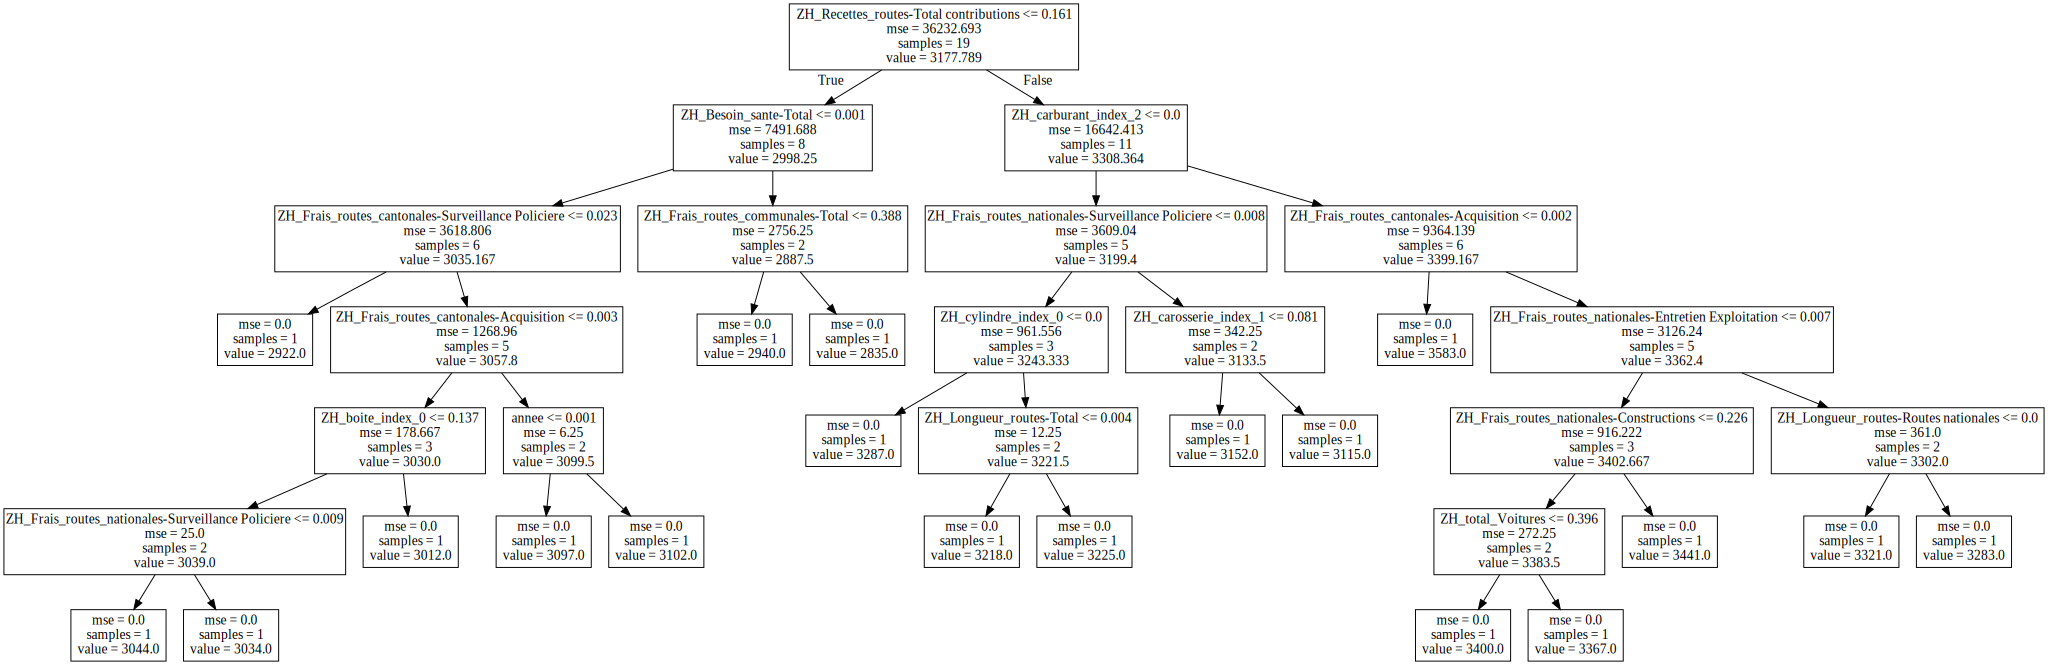

In [507]:
import graphviz
# To see the tree decision of a canton
canton = 'ZH'

clf = ML_stuff['tree']
X = normalize(features_cantons[canton].values)
        
clf.fit(X[:-1],accidents_cantons[canton][:-1])

tree = export_graphviz(clf,out_file=None,feature_names=features_cantons[canton].columns)

 
graphviz.Source(tree)